# Brainstation Final Project, Toronto Housing Prices

Wanna check out the webscraper I used? Full project here: https://github.com/taipeik9/toronto-realestate

In [72]:
from typing import Union

import pandas as pd
import numpy as np

import re

import h3

import matplotlib.pyplot as plt

import plotly.io as pio
import plotly.express as px
pio.renderers.default = "vscode" # change this if you are not using VSCode

from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

pd.set_option('plotting.backend', 'plotly')
pd.options.mode.chained_assignment = None  # default='warn'

## Loading the Datasets

I scraped 3 sites, all of which have similar listings. I will choose which one to use based on some factors.

In [73]:
trreb = pd.read_csv('data/trreb-jan17.csv', parse_dates=['added_at'])
realtor = pd.read_csv('data/realtorca-jan17.csv')
zoocasa = pd.read_csv('data/zoocasa-jan17.csv', parse_dates=['added_at'])

In [74]:
f"Dataset # of Rows: Trreb: {trreb.shape[0]}, Realtor.ca: {realtor.shape[0]}, Zoocasa: {zoocasa.shape[0]}"

'Dataset # of Rows: Trreb: 1495, Realtor.ca: 4046, Zoocasa: 3856'

Trreb has far less entries than the other two so I will not be using it for the model.

In [75]:
# Zoocasa has entries with "0 Room totals"
zoocasa['rooms_total'].replace(0.0, np.nan, inplace=True)

In [76]:
# Realtor.ca has more entries but also an inconvenient issue where the internal square footage is not included, but the room dimensions are
# this wouldn't be too hard to calculate but some rooms are missing, which was yield skewed results with our model.
realtor['room_dim_list'][0]

"19'4'' x 11'5'',14'8'' x 8'4'',8'9'' x 11'9'',4'10'' x 5'6'',5'5'' x 4'5'',15'0'' x 11'9''"

In [77]:
# Instead of a NaN value, the dataset comes out like this for rooms without available dimensions so I need to fix that.
realtor.room_dim_list[117]

'Measurements not available,Measurements not available,Measurements not available,Measurements not available,Measurements not available,Measurements not available,Measurements not available,Measurements not available,Measurements not available'

In [78]:
realtor['room_dim_list_fixed'] = realtor['room_dim_list'].str.replace('Measurements not available,', '').replace('Measurements not available', '')
realtor['room_dim_list_fixed'].replace('', np.nan, regex=True, inplace=True)
realtor.room_dim_list_fixed[117]

nan

In [79]:
z_potential_features = ['price', 'bedrooms', 'bedrooms_partial', 'bathrooms', 'bathrooms_partial', 'square_footage_min', 'square_footage_max', 'parking', 'type', 'garage_type', 'exterior', 'driveway_type', 'basement_type', 'features', 'levels', 'rooms_total', 'desc']
r_potential_features = ['price', 'bedrooms', 'bathrooms', 'archi_style', 'room_dim_list_fixed', 'parking', 'parking_type','type', 'exterior', 'utility', 'basement_type', 'features', 'levels', 'rooms_total', 'public_desc', 'heating', 'land_total']

## Counting NaN Values to Compare Datasets

In [80]:
# Realtor.ca
fig = px.bar(
    data_frame=realtor[r_potential_features].isna().sum(), 
    labels={'value': '# of NaN values', 'index': 'Features'},
    title="Realtor.ca NaN Count"
)
fig.update_layout(showlegend=False)
fig.show()

# Zoocasa
fig = px.bar(
    data_frame=zoocasa[z_potential_features].isna().sum(), 
    labels={'value': '# of NaN values', 'index': 'Features'},
    title="Zoocasa NaN Count"
)
fig.update_layout(showlegend=False)
fig.show()

Realtor.ca is missing almost all of its parking data, as well as its levels and architectural style. I believe these will be pretty essential for my model. As for the square footage, it is pretty similar for both sets of data. From this alone, I have chosen to use the Zoocasa data

In [81]:
# Second Zoocasa dataset, partially scraped 9 days after the first one.
zoocasa_2 = pd.read_csv('data/zoocasa-jan26.csv', parse_dates=['added_at'])
zoocasa_2['rooms_total'].replace(0.0, np.nan, inplace=True)

In [82]:
zoocasa_concat = pd.concat([zoocasa, zoocasa_2], axis=0)
zoocasa_concat.drop_duplicates(subset='mls_num', keep='first', inplace=True)
zoocasa_concat.reset_index(drop=True, inplace=True)
f"Second scrape added: {zoocasa_concat.shape[0] - zoocasa.shape[0]} listings"

'Second scrape added: 485 listings'

In [83]:
# Removing all listings added before 2022, not relevant
df = zoocasa_concat[(zoocasa_concat['added_at'].dt.year == 2022) | (zoocasa_concat['added_at'].dt.year == 2023)]

In [84]:
df = df[~df['square_footage_max'].isna() & ~df['square_footage_min'].isna()]
df = df[~df['rooms_total'].isna()]

In [85]:
df['fsa'] = df['postal_code'].str.slice(0,3)
df['bedrooms_partial'] = df['bedrooms_partial'].fillna(0)

In [86]:
df['fsa'].unique()

array(['M9M', 'M5A', 'M8V', 'M4S', 'M6M', 'M5S', 'M4Y', 'M1G', 'M4P',
       'M8Y', '000', 'M6P', 'M6E', 'M4V', 'M1E', 'M4L', 'M8X', 'M6K',
       'M2J', 'M5P', 'M5V', 'M4C', 'M1W', 'M5E', 'M1P', 'M9N', 'M2N',
       'M3A', 'M5R', 'M9R', 'M2R', 'M1M', 'M2M', 'M9V', 'M5J', 'M4W',
       'M1S', 'M4E', 'M6L', 'M6N', 'M6C', 'M9B', 'M3C', 'M1K', 'M3N',
       'M6B', 'M1B', 'M1J', 'M8Z', 'M9A', 'M6R', 'M1R', 'M3M', 'M8W',
       'M5M', 'M5G', 'M5T', 'M5B', 'M5C', 'M6J', 'M2H', 'M9C', 'M3J',
       'M2K', 'M6H', 'M3H', 'M4N', 'M4A', 'M9L', 'M6S', 'M4G', 'M6G',
       'M1N', 'M6A', 'M3K', 'M4K', 'M2P', 'M9W', 'M1T', 'M1V', 'M2L',
       'M1H', 'M4M', 'M3B', 'M5H', 'M1L', 'M9P', 'M5N', 'M4R', 'M1C',
       'M2S', 'M4T', 'M4B', 'M4H', 'M4J', 'M4X', 'M1X', 'L4J', 'TBA',
       'M3L', 'XXX', 'L9J', 'M2E', 'L1T', 'L9Y'], dtype=object)

In [87]:
df = df[(df['fsa'] != 'XXX') & (df['fsa'] != 'TBA')]

In [88]:
df.loc[:,~df.columns.isin(['id', 'bathrooms_partials', 'bedrooms_partials', 'lat', 'lon', 'neighbourhood_id'])].describe()

price     bedrooms  bedrooms_partial    bathrooms  \
count  3.146000e+03  3146.000000       3146.000000  3146.000000   
mean   1.073804e+06     1.935156          0.465035     1.958678   
std    9.485469e+05     1.008197          0.584553     1.088548   
min    1.000000e+00     0.000000          0.000000     1.000000   
25%    6.192220e+05     1.000000          0.000000     1.000000   
50%    7.584500e+05     2.000000          0.000000     2.000000   
75%    1.138972e+06     2.000000          1.000000     2.000000   
max    1.777500e+07     9.000000          5.000000     8.000000   

       bathrooms_partial  square_footage_min  square_footage_max      parking  \
count               4.00         3146.000000         3146.000000  3142.000000   
mean                0.25         1027.226319         1250.602988     1.536123   
std                 0.50          702.114558          866.709749    13.161575   
min                 0.00            0.000000          499.000000     0.000000   
25%                 0.00          600.000000          699.000000     1.000000   
50%                 0.00          900.000000          999.000000     1.000000   
75%                 0.25         1200.000000         1399.000000     1.000000   
max                 1.00         4750.000000         5000.000000   706.000000   

       rooms_total  
count  3146.000000  
mean      6.276860  
std       2.196388  
min       1.000000  
25%       5.000000  
50%       6.000000  
75%       7.000000  
max      13.000000

The parking maximum is way too high and the minimum price is far too low. So I will have to clean those up

In [89]:
# deleting any parking number that is above 3 standard deviations from the mean. 
# There are no negative "parking spots" so I only need to check in the positive direction
df = df[df['parking'] < (df['parking'].describe()['std']*3 + df['parking'].describe()['mean'])]
df['parking'].describe()

count    3138.000000
mean        1.207616
std         1.296250
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        12.000000
Name: parking, dtype: float64

In [90]:
# I just kind of arbitrarily decided that any property under $200 000 in Toronto is an outlier
df = df[df['price'] > 200000]
df['price'].describe()

count    3.134000e+03
mean     1.075834e+06
std      9.494392e+05
min      2.340000e+05
25%      6.199000e+05
50%      7.590000e+05
75%      1.139675e+06
max      1.777500e+07
Name: price, dtype: float64

In [91]:
f"# of Valid Rows: {df.shape[0]}"

'# of Valid Rows: 3134'

In [92]:
import plotly.graph_objects as go

fig = px.scatter_mapbox(df, lat='lat', lon='lon', color='price',
             color_continuous_scale= [
                [0.0, "green"],
                [0.05, "green"],
                [0.05111111, "yellow"],
                [0.11111111, "yellow"],
                [0.11111112, "red"],
                [1, "red"]],
                opacity = 0.5,
                hover_name="address", 
                hover_data=["square_footage_min", "square_footage_max", "type", "levels", "bedrooms", "bathrooms"],
                zoom=10
            )

fig.update_layout(mapbox_style="carto-darkmatter")
fig.update_layout(margin=dict(b=0, t=0, l=0, r=0))
fig.show()

We are already beginning to see some patterns in terms of location. The locations surrounding yonge street seem consistently higher priced than those in other areas. As well there is a more dense area of listings towards the centre of the visualization and a large group in the southern portion (downtown Toronto)

## Grouping Common Values
For the language portions of the data, a lot of the categories can be grouped together. I will be looking at the unique values in a couple different columns and grouping them together if they are similar enough / they are not confounding.

In [93]:
df['type'].value_counts()

Condo Apt             2409
Detached               272
Condo Townhouse        222
Comm Element Condo      77
Semi-Detached           60
Att/Row/Twnhouse        40
Co-Op Apt               15
Co-Ownership Apt        11
Leasehold Condo          8
Triplex                  5
Duplex                   4
Multiplex                3
Store W/Apt/Offc         2
Attached                 2
Link                     1
Fourplex                 1
Det Condo                1
Name: type, dtype: int64

In [94]:
df['type'].replace(['Comm Element Condo', 'Det Condo', ], 'Condo Apt', inplace=True)
df['type'].replace(['Co-Ownership Apt'], 'Co-Op Apt', inplace=True)
df['type'].replace(['Duplex', 'Triplex', 'Fourplex'], 'Multiplex', inplace=True)
df = df[df['type'] != 'Store W/Apt/Offc']
df = df[df['type'] != 'Link']
df.type.value_counts()

Condo Apt           2487
Detached             272
Condo Townhouse      222
Semi-Detached         60
Att/Row/Twnhouse      40
Co-Op Apt             26
Multiplex             13
Leasehold Condo        8
Attached               2
Name: type, dtype: int64

In [95]:
df['levels'].replace('Bungalow-Raised', 'Bungalow', inplace=True)
df['levels'].replace(['Multi-Level', 'Condo/Apt Unit', 'Bachelor/Studio'], 'Apartment', inplace=True)
df = df[df['levels'] != "Other"]
df.levels.value_counts()

Apartment          2401
2-Storey            358
3-Storey            135
Stacked Townhse      74
Loft                 66
Bungalow             47
2 1/2 Storey         23
1 1/2 Storey         12
Sidesplit 4           4
Backsplit 4           3
Sidesplit 3           2
Backsplit 3           1
Sidesplit 5           1
Name: levels, dtype: int64

In [96]:
df.loc[df['basement_type'].str.contains('Apartment', na=False), 'basement_type'] = 'None'
df.loc[df['basement_type'].str.contains('Other', na=False), 'basement_type'] = 'None'
df.loc[df['basement_type'].str.contains('None and Other', na=False), 'basement_type'] = 'None'
df.loc[df['basement_type'].str.contains('Fin', na=False), 'basement_type'] = 'Finished'
df.loc[df['basement_type'].str.contains('Finished', na=False), 'basement_type'] = 'Finished'
df.loc[df['basement_type'].str.contains('Unfinished', na=False), 'basement_type'] = 'Unfinished'
df.loc[df['basement_type'].str.contains('Part Bsmt', na=False), 'basement_type'] = 'Unfinished'
df.loc[df['basement_type'].str.contains('Sep Entrance', na=False), 'basement_type'] = 'Sep Entrance'
df.loc[df['basement_type'].str.contains('W/O', na=False), 'basement_type'] = 'Sep Entrance'
df.loc[df['basement_type'].str.contains('Walk-Up', na=False), 'basement_type'] = 'Sep Entrance'
df.loc[df['basement_type'].str.contains('Full', na=False), 'basement_type'] = 'Finished'
df.loc[df['basement_type'].str.contains('Half', na=False), 'basement_type'] = 'None'
df.loc[df['basement_type'].str.contains('Crawl Space', na=False), 'basement_type'] = 'None'
df['basement_type'].value_counts()

None            2706
Finished         356
Unfinished        36
Sep Entrance      13
Name: basement_type, dtype: int64

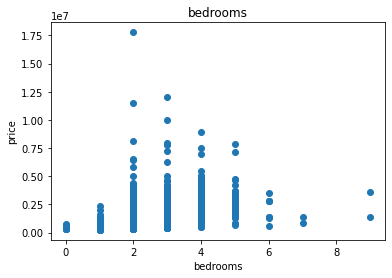

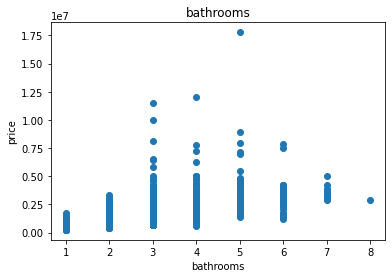

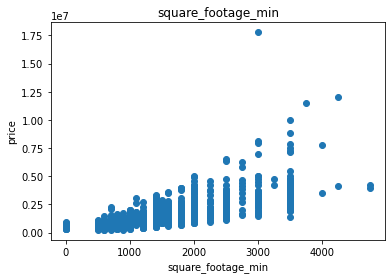

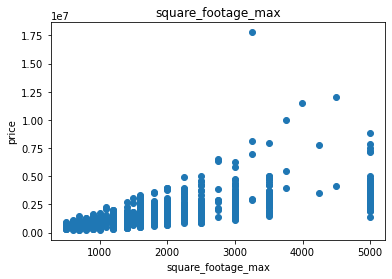

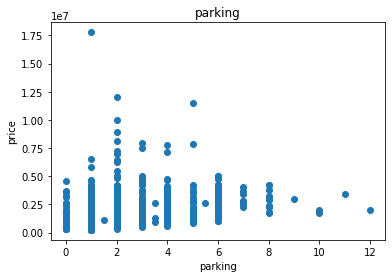

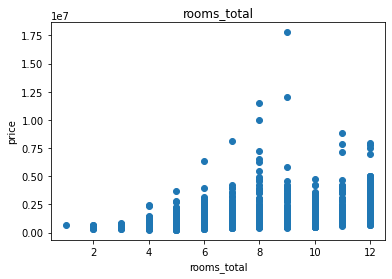

In [97]:
numerical_features = ['bedrooms', 'bathrooms', 'square_footage_min', 'square_footage_max', 'parking', 'rooms_total']
# a group of scatter plots to better visualize linear relationships between listing variables and price
for feature in numerical_features:
    plt.scatter(x=df[feature], y=df["price"])
    plt.title(feature)
    plt.ylabel('price')
    plt.xlabel(feature)
    plt.show()

There is a counterintuitive relationship here, which is that it seems the less parking spaces we have, the higher the price is. One explanation for this could be the correlation between parking spaces and whether or not a listing is a condo. Condos are generally cheaper than houses, but can have more parking spaces

In [98]:
f"{df['fsa'].nunique()} zones/neighbourhoods"

'103 zones/neighbourhoods'

In [99]:
features = ['price', 'bedrooms', 'bedrooms_partial', 'bathrooms', 'square_footage_min', 'square_footage_max', 'parking', 'type', 'levels', 'rooms_total', 'fsa']

In [100]:
fig = px.imshow(df[features].corr())
fig.show()

This shows that there is still a positive relationship with between parking and price, its just not one of the stronger ones

# Creating the Model!

## Model Notes:

First iteration of the model was 75% R2. It included houses and only properties under 4 000 000 dollars.

In [101]:
features = ['price', 'bedrooms', 'bedrooms_partial', 'bathrooms', 'square_footage_min', 'square_footage_max', 'parking', 'type', 'levels', 'rooms_total', 'fsa']

In [102]:
model_df = df[features]
model_df = model_df[model_df['price'] <= 4000000].reset_index(drop=True)
X = model_df.drop(columns='price')
y = model_df['price']

In [103]:
X = pd.get_dummies(data=X, drop_first=True)

In [104]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # test data

In [105]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [106]:
lr.fit(X_train, y_train)

LinearRegression()

In [107]:
c = lr.intercept_
m = lr.coef_

In [108]:
y_predictions = lr.predict(X_train)

In [109]:
# 70% accuracy including houses over $4000000, 75% excluding them
y_pred_test = lr.predict(X_test)
r2_score(y_test, y_pred_test)

0.7651013863337287

In [144]:
px.scatter(x=y_test, y=y_pred_test, trendline='ols', labels={'y': 'Predicted Price', 'x': 'Actual Price'})

## Thoughts

The exclusion of houses actually reduced the r2 score of our model (75% to 70%).

A linear regression model including only sqft and fsa has a 67% r squared score, only 3% less than including the other features.

Are there ways I can account for location without categorizing the listings by FSA and adding all of those features? I think the model may be over fit because changing around the random state changes the R2 score by a significant degree.

Ideas:
- Proximity to center of Toronto
- Look at stats to do with FSA / district (median household income)
- Proximity to schools and school ratings
- Proximity to TTC?
- Number of Starbucks in region?
- Uber Hexagon clustering
- Unsupervised clustering using Kmeans

Also heating and heating type + Kitchen size?

I looked through the Zoocasa data once again and I have decided to touch up my scraper a bit to include more pertinent info. I think that Zoocasa provides data on schools / neighbourhood data. I found that you can scrape all of the sold listings too. So I have done that and will combine the datasets

# Let's Make Some Functions!

The first few functions will be the data loading & cleaning functions

These include: format_zoocasa(), group_zoocasa(), concat_zoocasa() and load_zoocasa()

In [111]:
def format_zoocasa(df: pd.DataFrame, condos_only: bool = False, houses_only: bool = False, H3_res : int = 7) -> pd.DataFrame:
    """This function formats the scraped Zoocasa data in numerous ways.

    Args:
        df (pd.DataFrame): your scraped Zoocasa dataframe
        condos_only (bool): keep only condos
        houses_only (bool): keep only houses
        H3_res (int): resolution of H3 segmentation. Default 7

    Returns:
        pd.DataFrame: a formatted Zoocasa dataframe
    """
    

    # Removing all listings added before 2022, not relevant
    df = df[(df['added_at'].dt.year == 2022) | (df['added_at'].dt.year == 2023)]

    # Removing all null sqft and total rooms
    df = df[~df['square_footage_max'].isna() & ~df['square_footage_min'].isna()]
    
    if 'rooms_total' in df.columns:
        # replacing 0 room totals with NaN values
        df['rooms_total'].replace(0.0, np.nan, inplace=True)
        df = df[~df['rooms_total'].isna()]

    # Creating a square footage column with the average of min and max
    df['square_footage'] = df[['square_footage_min', 'square_footage_max']].mean(axis=1)

    # Filling partial bedroom nulls with 0
    df['bedrooms_partial'] = df['bedrooms_partial'].fillna(0)
    
    # adding all partial bedrooms to bedrooms column with half value
    df['bedrooms'] = df['bedrooms'] + (df['bedrooms_partial']/2)

    # Creating FSA Column
    df['fsa'] = df['postal_code'].str.slice(0,3)
    df = df[(df['fsa'] != 'XXX') & (df['fsa'] != '0') & \
    (df['fsa'] != '000') & (df['fsa'] != 'TBA') & \
    (df['fsa'] != 'TBD') & (df['fsa'] != '190')] # if listing has no postal code

    # Formatting lot frontage and lot depth (For houses)
    if ('lot_frontage' in df.columns) and ('lot_depth' in df.columns):
        df['lot_frontage'].fillna(0, inplace=True)
        df['lot_frontage'] = df['lot_frontage'].apply(lambda x : int(re.search(r'\d+', str(x)).group()))
        df['lot_depth'].fillna(0, inplace=True)
        df['lot_depth'] = df['lot_frontage'].apply(lambda x : int(re.search(r'\d+', str(x)).group()))


    def geo_to_h3(row):
      return h3.geo_to_h3(lat=row.lat,lng=row.lon,resolution = H3_res)
    df['h3_cell'] = df.apply(geo_to_h3,axis=1)

    # Creating a distance from Toronto column
    df['dis_from_tor'] = df.apply(lambda x : h3.point_dist((x['lat'], x['lon']), (43.7064, -79.3986), unit='m'), axis=1)

    # deleting any parking number that is above 2 standard deviations from the mean. 
    # There are no negative "parking spots" so I only need to check in the positive direction
    df = df[df['parking'] < (df['parking'].describe()['std']*2 + df['parking'].describe()['mean'])]

    # I just kind of arbitrarily decided that any property under $200 000 in Toronto is an outlier
    df = df[df['price'] > 200000]

    if ('type' in df.columns) and ('levels' in df.columns):
        df = group_zoocasa(df, condos_only, houses_only)

    return df


def group_zoocasa(df: pd.DataFrame, condos_only: bool = False, houses_only: bool = False) -> pd.DataFrame:
    """Groups together the 'type' and 'levels' columns to reduce number of features.

    Args:
        df (pd.DataFrame): formatted Zoocasa listing dataframe
        condos_only (bool): if only condos in dataframe
        houses_only (bool): if only houses in dataframe

    Returns:
        pd.DataFrame: _description_
    """

    # Included Condo Types: Condo Apt, Condo Townhouse, Comm Element Condo, Co-Ownership Apt, Leasehold Condo
    # Included Levels: Apartment, 2-Storey, Stacked Townhse, Loft, 3-Storey, Multi-Level, Bachelor/Studio


    df.levels.replace('Bungalow-Raised', 'Bungalow', inplace=True)
    df.levels.replace(['Loft', 'Bachelor/Studio'], 'Apartment', inplace=True)
    df['type'].replace(['Comm Element Condo'], 'Condo Apt', inplace=True)

    if condos_only:
        type_keep = ['Condo Apt', 'Condo Townhouse', 'Att/Row/Twnhouse']
        levels_keep = ['Apartment', '1 1/2 Storey', '2-Storey', '3-Storey', 'Stacked Townhse', '2 1/2 Storey']
    elif houses_only:
        type_keep = ['Detached', 'Semi-Detached']
        levels_keep = ['1 1/2 Storey', '2-Storey', '3-Storey', 'Bungalow', '2 1/2 Storey']
    else:
        type_keep = ['Condo Apt', 'Detached', 'Condo Townhouse', 'Att/Row/Twnhouse', 'Semi-Detached']
        levels_keep = ['Apartment', '1 1/2 Storey', '2-Storey', '3-Storey', 'Stacked Townhse', 'Bungalow', '2 1/2 Storey']
    
    df = df[df['type'].isin(type_keep)]
    df = df[df['levels'].isin(levels_keep)]

    return df


def concat_zoocasa(dfs: list[pd.DataFrame]) -> pd.DataFrame:
    """concats multiple zoocasa dataframes and drops duplicate listing by MLS num

    Args:
        dfs (list): list of dataframes to concat

    Returns:
        pd.DataFrame: _description_
    """
    df = pd.concat(dfs, axis=0)
    df.drop_duplicates(subset='id', keep='first', inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df


def load_zoocasa(data_loc: list[str]) -> Union[list[pd.DataFrame], pd.DataFrame]:
    """_summary_

    Args:
        data_loc (list[str]): list of strings indicating scraped data(s) from the Zoocasa scraper

    Returns:
        list[pd.DataFrame]: list of Pandas dataframes with the dates parsed
        pd.DataFrame: Pandas dataframe with the dates parsed
    """
    if len(data_loc) > 1:
        return [pd.read_csv(data, parse_dates=['added_at']) for data in data_loc]
    else:
        return pd.read_csv(data_loc[0], parse_dates=['added_at'])

The next few functions will be the model selection/validation/creation functions.

In [112]:
def prep_data(df: pd.DataFrame, features: list[str], price_cap: int = 4000000) -> tuple[pd.DataFrame, pd.Series]:
    model_df = df[features]
    model_df = model_df[model_df['price'] <= price_cap].reset_index(drop=True)
    X = model_df.drop(columns='price')
    y = model_df['price']
    X = pd.get_dummies(data=X, drop_first=True)

    return X, y
    

def create_model(df: pd.DataFrame, features: list[str], model: any, price_cap: int = 4000000, random_state: int = 42, test_size: int = 0.3) -> tuple[any, dict[str, pd.DataFrame]]:
    """creates a regression model based on inputted data

    Args:
        df (pd.DataFrame): formatted Zoocasa listing dataframe
        features (list): list of features to include in the model (include price as well)
        model (any): sklearn model to use
        model_args (dict): arguments for model
        price_cap (int): price ceiling of listings to include in model
        random_state (int): desired random_state of split ex. 0, 1, 42. Default 42
        test_size (int): desired test_size of split

    Returns:
        any: regression model
        list[pd.DataFrame]: dict of val dataframes
    """
    X, y = prep_data(df, features, price_cap)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state) # val data

    split = {
        'X_val' : X_val,
        'y_val' : y_val,
        'X_train' : X_train,
        'y_train' : y_train
    }

    return model.fit(X_train, y_train), split


def cv_kfold(df: pd.DataFrame, features: list[str], model: any, n_splits: int = 5, price_cap: int = 4000000, full_scores: bool = False) -> str:
    """Get the kfold cross validation score for model

    Args:
        df (pd.DataFrame): Zoocasa pandas dataframe
        features (list[str]): feature list (including price)
        model (any): your regression model
        n_splits (int, optional): amount of splits of the kfold. Defaults to 5.
        price_cap (int, optional): maximum listing price. Defaults to 4000000.

    Returns:
        str: Kfold Cross Validation Scores
    """
    X, y = prep_data(df, features, price_cap=price_cap)

    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    r2_scores, mae_scores, rmse_scores, mape_scores = [], [], [], []
    for train_index, test_index in kf.split(X):
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        r2_scores.append(model.score(X_test, y_test))
        mae_scores.append(mean_absolute_error(model.predict(X_test), y_test))
        rmse_scores.append(np.sqrt(mean_squared_error(model.predict(X_test), y_test)))
        mape_scores.append(mean_absolute_percentage_error(model.predict(X_test), y_test))
    if full_scores:
        return {
            'Total R2 Scores' : r2_scores, 'Mean R2 Score' : sum(r2_scores)/n_splits,
            'Total Mean Absolute Errors' : mae_scores, 'Mean MAE' : sum(mae_scores)/n_splits,
            'Total Mean RMSE' : rmse_scores, 'Mean RMSE' : sum(rmse_scores)/n_splits,
            'Total Mean MAPE' : mape_scores, 'Mean MAPE' : sum(mape_scores)/n_splits
        }
    else:
        return {
            'R2 Score' : sum(r2_scores)/n_splits,
            'MAE' : sum(mae_scores)/n_splits,
            'RMSE' : sum(rmse_scores)/n_splits,
            'MAPE' : sum(mape_scores)/n_splits
        }

def predict(val_data: dict[str: pd.DataFrame], model: any) -> tuple[np.ndarray, np.ndarray]:
    """Generates the test predictions from regression model and R2 scores

    Args:
        val_data (dict): validation data from split
        model (any): Regression model

    Returns:
        tuple[np.ndarray]: predictions on train and test data
    """

    y_train_predictions = model.predict(val_data['X_train'])
    y_test_predictions = model.predict(val_data['X_val'])

    return y_train_predictions, y_test_predictions

## Taking a look at the new dataset and Optimizing the model

I changed some things around with the scraper and realized that Zoocasa allows you to view all sold listings as well as the available ones. So I made a larger dataset involving the past listings as well as availables for 2022 and 2023.

In [113]:
data_locations = ['data/zoocasa-feb-2-sold.csv', 'data/zoocasa-feb-2-available.csv']
df_list = load_zoocasa(data_locations)
df = concat_zoocasa(df_list)

df = format_zoocasa(df)

In [114]:
df.shape # ~6 times more valid listings than the last dataset

(18530, 41)

In [115]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'parking', 'type', 'heating', 'heating_fuel', 'lot_frontage',
       'lot_depth', 'ac', 'exterior', 'driveway_type', 'basement_type', 'levels', 'rooms_total', 'rooms_dimensions', 'fsa', 'dis_from_tor']

df[features].describe()

price      bedrooms     bathrooms  square_footage       parking  \
count  1.853000e+04  18530.000000  18530.000000    18530.000000  18530.000000   
mean   9.703634e+05      2.127469      1.858877     1076.983108      1.239342   
std    7.186011e+05      1.060858      1.009480      702.642868      1.263184   
min    2.340000e+05      0.000000      1.000000      249.500000      0.000000   
25%    5.999000e+05      1.500000      1.000000      649.500000      1.000000   
50%    7.399000e+05      2.000000      2.000000      849.500000      1.000000   
75%    9.990000e+05      2.500000      2.000000     1299.500000      1.000000   
max    1.200000e+07     10.500000     11.000000     4874.500000     15.000000   

       lot_frontage     lot_depth   rooms_total  dis_from_tor  
count  18530.000000  18530.000000  18530.000000  18530.000000  
mean       5.046681      5.046681      6.313384   7811.561907  
std       13.727203     13.727203      2.231359   3692.704124  
min        0.000000      0.000000      1.000000     68.730589  
25%        0.000000      0.000000      5.000000   5779.160803  
50%        0.000000      0.000000      6.000000   7179.923117  
75%        0.000000      0.000000      7.000000   9704.525616  
max      166.000000    166.000000     12.000000  23731.095520

In [116]:
px.bar(df[features].corr()['price'], x=df[features].corr().index, y='price', labels={'price': 'Correlation', 'x' : 'Features'}, title='Correlation with Price')

This is another kind of visualization for correlation which I actually prefer over a heatmap.

Below I use the new functions to try out a linear regression model on the new dataset

In [117]:
data_locations = ['data/zoocasa-feb-2-sold.csv', 'data/zoocasa-feb-2-available.csv']
df_list = load_zoocasa(data_locations)
df = concat_zoocasa(df_list)

df = format_zoocasa(df)

In [118]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'parking', 'rooms_total', 'type', 'levels', 'fsa']
cv_kfold(df, features, LinearRegression())

{'R2 Score': 0.8009378515580602,
 'MAE': 161209.45577570534,
 'RMSE': 250175.2381872828,
 'MAPE': 0.18662626051876427}

~80% R squared score with new dataset, slightly better than our previous dataset. And of course, I am now using k fold cross validation to further prevent over fitting

Lets try out Random Forest Regression

In [119]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'parking', 'rooms_total', 'type', 'levels', 'fsa']
cv_kfold(df, features, RandomForestRegressor())

{'R2 Score': 0.838474882120253,
 'MAE': 129897.53799536059,
 'RMSE': 225297.95721461475,
 'MAPE': 0.12399851914035617}

The Random Forest model shows improvement over the linear regression model by ~3%

Lets try out XGBoost Regression:

In [120]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'parking', 'type', 'levels', 'fsa']
cv_kfold(df, features, XGBRegressor())

{'R2 Score': 0.8624341066829558,
 'MAE': 124374.24402988383,
 'RMSE': 207983.04090926028,
 'MAPE': 0.12116405983643705}

The XGBoost model shows improvement over the Random Forest model by ~2% and its train time is about one third of the RF model. And oddly I found that removing the total rooms feature improves the accuracy as well. This could indicate that there are some errors in the dataset, or that total rooms doesn't really affect the price. Either way, the effect of the "room count" is already accounted for in the total square footage

## Tuning Location in Model

Location, location, location. FSA is not necessarily a good measure for location.

Here I explore a couple of other different options to account for location

In [145]:
fig = px.scatter_mapbox(df[df['price'] <= 4000000], lat='lat', lon='lon', color='price',
             color_continuous_scale= px.colors.sequential.Hot,
                opacity = 0.5,
                hover_name="address", 
                hover_data=["square_footage", "type", "levels", "bedrooms", "bathrooms"],
                zoom=10
            )

fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin=dict(b=0, t=0, l=0, r=0))
fig.show()

Adding distance from centre of Toronto as a metric, (yonge and eglinton)

In [122]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'parking', 'type', 'levels', 'fsa', 'dis_from_tor']

cv_kfold(df, features, XGBRegressor())

{'R2 Score': 0.8728618013660787,
 'MAE': 117065.1931443257,
 'RMSE': 199901.60031648976,
 'MAPE': 0.11274634909198289}

Distance from Toronto as a metric improved model accuracy by ~1%. Trying out Uber H3 Hexagon's instead of FSA

![Uber H3 Hexagons](http://eng.uber.com/wp-content/uploads/2018/06/image12.png)

In [123]:
# Uber's H3 Hexagon Clustering (This has been added to the format function)
# H3_res = 7
# def geo_to_h3(row):
#   return h3.geo_to_h3(lat=row.lat,lng=row.lon,resolution = H3_res)

# df['h3_cell'] = df.apply(geo_to_h3,axis=1)

In [124]:
data_locations = ['data/zoocasa-feb-2-sold.csv', 'data/zoocasa-feb-2-available.csv']
df_list = load_zoocasa(data_locations)
df = concat_zoocasa(df_list)

df = format_zoocasa(df, H3_res=6)

In [125]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'rooms_total', 'parking', 'type', 'levels', 'h3_cell', 'dis_from_tor']

cv_kfold(df, features, XGBRegressor())

{'R2 Score': 0.8705378869224093,
 'MAE': 118476.6393304914,
 'RMSE': 201701.19853977143,
 'MAPE': 0.1136141302642828}

H3 does perform with slightly less accuracy than FSA, but there is an upside to it, as you can adjust the size of the groups. This is useful for when you are dealing with large datasets, like all of Ontario. There may be too many FSAs for the model to handle. K-Means Clustering also yields accuracy than H3 and FSA.

Because we moved from a linear regression model to a gradient boosting method, we can also try lat lon, as this model doesn't require that the variables have a linear relationship

In [126]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'parking', 'type', 'levels', 'lat', 'lon']

cv_kfold(df, features, XGBRegressor())

{'R2 Score': 0.8864822918412842,
 'MAE': 109262.03002141349,
 'RMSE': 188885.18322843526,
 'MAPE': 0.10420862279811663}

Through playing around a bit with the model, I found that a combination of resolution 6 H3 Uber cells, the distance from Toronto and lat lons were the best combination of features

In [127]:
data_locations = ['data/zoocasa-feb-2-sold.csv', 'data/zoocasa-feb-2-available.csv']
df_list = load_zoocasa(data_locations)
df = concat_zoocasa(df_list)

df = format_zoocasa(df, H3_res=6)

In [128]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'parking', 'type', 'levels', 'lat', 'lon', 'dis_from_tor', 'h3_cell']

cv_kfold(df, features, XGBRegressor())

{'R2 Score': 0.8908680864146955,
 'MAE': 107747.40128437374,
 'RMSE': 185312.50619167212,
 'MAPE': 0.10309477386631812}

## Accounting for Date

Something that I probably should have tried earlier, was to account for date lmao. So I will explore that here

In [129]:
time_df = df.set_index('added_at')

In [130]:
time_g = time_df.groupby(pd.Grouper(freq='M'))['price'].mean().to_frame()
time_g.rename(columns={'price': 'mean_price'}, inplace=True)
time_g['median_price'] = time_df.groupby(pd.Grouper(freq='M'))['price'].median()

In [131]:
px.line(time_g, title="Mean and Median Price Over 2022", labels={'value' : 'Price', 'added_at' : 'Month'})

From this visualization we can see that date may be a confounding factor in price

Including the epoch time as a feature has decreased the performance of the model, but the real estate market is cyclical. Maybe it would help to change the date into categorical features, such as season or month?

In [132]:
df['month_year'] = pd.to_datetime(df['added_at']).dt.to_period('M').astype(str)
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'parking', 'type', 'levels', 'lat', 'lon', 'dis_from_tor', 'h3_cell', 'month_year']

cv_kfold(df, features, XGBRegressor())

/Users/henrybrown/opt/anaconda3/envs/data_analysis/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



{'R2 Score': 0.8884444565659487,
 'MAE': 108673.24641592083,
 'RMSE': 187324.54530334804,
 'MAPE': 0.10385721401810022}

In [133]:
season_dict = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'}
df['season'] = df['added_at'].apply(lambda x: f"{season_dict[x.month]} {x.year}")

features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'parking', 'type', 'levels', 'lat', 'lon', 'dis_from_tor', 'h3_cell', 'season']

cv_kfold(df, features, XGBRegressor())

{'R2 Score': 0.8881363727913565,
 'MAE': 108537.42665623981,
 'RMSE': 187562.52910912246,
 'MAPE': 0.10367766597258307}

Accounting for date / time of year does not seem to improve the model, but I also didn't split it by time

## Hyperparameter tuning the XGBoost model

Hyperparameter tuning can be an effective way at improving a model's performance. Below I chose some basic parameters of the XGBRegressor to try out on the dataset and see which is best

In [134]:
data_locations = ['data/zoocasa-feb-2-sold.csv', 'data/zoocasa-feb-2-available.csv']
df_list = load_zoocasa(data_locations)
df = concat_zoocasa(df_list)

df = format_zoocasa(df, H3_res=6)

In [135]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'parking', 'type', 'levels', 'lat', 'lon', 'dis_from_tor', 'h3_cell']

X, y = prep_data(df, features)

In [136]:
param_grid = { 
    "max_depth" : [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.3, 0.7],
    'n_estimators' : [100, 500, 1000]
    }
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [137]:
xg = XGBRegressor(seed=20)

In [138]:
# # This cell takes a long time to run and is commented out
# # Define grid search
# grid_search = GridSearchCV(estimator=xg, 
#                            param_grid=param_grid, 
#                            scoring=['r2'], 
#                            refit='r2', 
#                            n_jobs=-1, 
#                            cv=kfold, 
#                            verbose=0)
# # Fit grid search
# grid_result = grid_search.fit(X, y)
# # Print grid search summary
# grid_result
# # Print the best score and the corresponding hyperparameters
# print(f'The best score is {grid_result.best_score_:.4f}')
# print(f'The best hyperparameters are {grid_result.best_params_}')

The best score is 0.9012
The best hyperparameters are 

```{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000}```

In [139]:
cv_kfold(df, features, XGBRegressor(**{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000}))

{'R2 Score': 0.902753597224832,
 'MAE': 99564.14438187047,
 'RMSE': 174812.59983389833,
 'MAPE': 0.09428840677518102}

With the hyperparameter tuning we were able to reach an R2 score of 90.3%, a mean absolute error of $99 564, a root mean squared error of $174 813 and mean absolute percentage error of 9.4%

In [140]:
features = ['price', 'bedrooms', 'bathrooms', 'square_footage', 'parking', 'type', 'levels', 'lat', 'lon', 'dis_from_tor', 'h3_cell']

xg, split_data = create_model(df, features, XGBRegressor(**{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1000}))
y_train_predictions, y_test_predictions = predict(split_data, xg)

In [141]:
split_data['X_val']['price'] = split_data['y_val']
split_data['X_val']['price_predictions'] = y_test_predictions
split_data['X_val']['error_percent'] = abs((split_data['X_val']['price_predictions'] - split_data['X_val']['price']) / ((split_data['X_val']['price_predictions'] + split_data['X_val']['price'])/2)*100)
split_data['X_val']['error'] = (split_data['X_val']['price_predictions'] - split_data['X_val']['price'])
error = pd.merge(split_data['X_val'], df)

fig = px.scatter_mapbox(error, lat='lat', lon='lon', color='error_percent',
             color_continuous_scale= px.colors.sequential.Plotly3,
                opacity = 0.5,
                hover_name="address", 
                hover_data=["square_footage", "type", "levels", "bedrooms", "bathrooms"],
                zoom=10
            )

fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin=dict(b=0, t=0, l=0, r=0))
fig.show()

This is a map of the error comparing the predicted prices to our model. The more pink/purple the dot is, the higher percent of error the with the model prediction. The key insight about the model that we can take away is that our model is predicting wrong in areas with less data than others. So, probably, for further improvement, we would need more data points. 

In [142]:
px.scatter(x=split_data['y_val'], y=y_test_predictions, trendline='ols', labels={'y': 'Predicted Price', 'x' : 'Actual Price'})

The predicted and actual price from our test set is graphed here. And we can see a pattern of both less data points as our price increases and less model accuracy

In [143]:
pd.DataFrame(xg.get_booster().get_score().items()).sort_values(by=1, ascending=False).head(10)

0       1
4               lat  8485.0
5               lon  7811.0
6      dis_from_tor  6963.0
0          bedrooms  5041.0
2    square_footage  4941.0
3           parking  2292.0
1         bathrooms  2270.0
12  levels_2-Storey   407.0
9     type_Detached   304.0
7    type_Condo Apt   278.0

In terms of statistical inference, the classic realtor motto is re-affirmed in that location is the most important feature when it comes to housing. The first three most important features are to do with location and followed by square footage, then number of bedrooms, then parking, then number of bathrooms. With the actual type of the property being behind all three of these factors.

## Looking forward

There are lots of things that I couldn't get from the scraper, either because not enough listings provided that data, or the site didn't allow for it. Things like renovations, age of building, and other amenities that come along with a condo affect the price. Whether or not it comes furnished. There is a column that I scraped with the descriptions and extras for each listing. A possible way of improvement could be to use NLP to extract keywords for those and then add that in as a categorical feature for the model.

We also have a list of room dimensions, exterior, basement type and garage type. But as shown earlier I had some trouble with cutting these categories down into succinct groups. Other than that, we probably just need more data to get better results. It would be possible to run this scraper every year and then you would have a fuller dataset to train your model with. But over time you would need to better account for the date than I did here